# Part 2: Image Segmentation Tutorial - Lung CT



### Task: Automatically Detect Lungs in CT Scan


##### Reference: https://www.kaggle.com/code/travishong/image-segmentation-for-lung-ct/notebook


### Installs and imports - PLEASE RESTART KERNEL AFTER INSTALLING PACKAGES


In [37]:
# %%time
# pip install numpy matplotlib scikit-learn scikit-image tensorflow keras simpleitk pydicom nibabel tqdm

In [12]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import os, glob
import zipfile
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

### Load Data: Images and Masks


In [19]:
path = '/Users/danishkarur/opt/Python Scripts/Learnings_CognitiveClasses/LungCT_platform/2d_images'

img_list = sorted(glob.glob(path + '/*.tif'))
print('Image list length ',len(img_list))
# mask_list = sorted(glob.glob(path + 'NIfTI_masks/*.nii'))

# print(f'Total number of images and masks:',len(img_list), len(mask_list))

# loading images from zip file (it takes few minutes)

# import zipfile
# from tqdm import tqdm

# with zipfile.ZipFile("2d_images.zip.zip", "r") as zip_ref:
#     # get the total number of files in the zip file
#     total_files = len(zip_ref.infolist())

#     # iterate over the files in the zip file and extract them
#     for file in tqdm(zip_ref.infolist(), total=total_files):
#         zip_ref.extract(file, "data_sample")

# removing one unwanted file in the data_sample folder
# os.remove("data_sample/data_sample/.DS_Store")

Image list length  267


### Preprocessing Steps


In [20]:
# create numpy array placeholder for pixels with 1 channel (grey scale)
IMG_SIZE = 256
x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
# ^ 1st arg: (# of numpy set(x_data, y_data), length of numpy set, height, width, color channel)

In [21]:
# convert images to numpy arrays
for i, img_path in enumerate(img_list):
    # load image
    img = imread(img_path)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    x_data[i] = img

# convert mask images to numpy arrays
for i, img_path in enumerate(mask_list):
    # load image
    img = imread(img_path)

    # rotate the mask to align with dicom image
    img_rot = np.moveaxis(img, 0, 1)
    
    # resize image with 1 channel
    img = resize(img_rot, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    
    # save to x_data
    y_data[i] = img

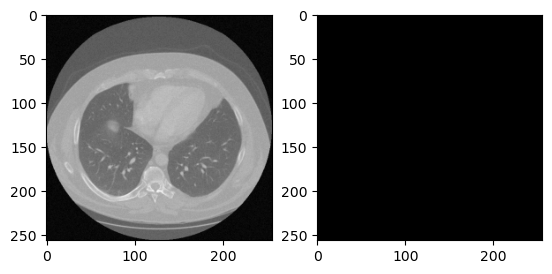

In [22]:
# scale image arrays
# scaling benefits learning process 
x_data /= 255
y_data /= 255

# display samples of image and mask in gray scale
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[5].squeeze(), cmap='gray')
ax[1].imshow(y_data[5].squeeze(), cmap='gray')
# ^ since imshow takes 2d array, 3d array is squeezed down to 2d by removing single dimensional entry

In [23]:
# train and validation data split
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2)

print(f'Training samples shape:', x_train.shape)
print(f'Validation or Test samples shape', x_val.shape)

Training samples shape: (213, 256, 256, 1)
Validation or Test samples shape (54, 256, 256, 1)


### Model Training


In [24]:
# Define a simple encoder-decoder model
inputs = Input(shape=(256, 256, 1))

# encoding
net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)
net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)
net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

# decoding
net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)
net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)
net = UpSampling2D(size=2)(net)

# output with 1 channel for gray scale segmenation
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

# use binary cross entropy with sigmoid function 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

In [25]:
%%time
# reduce learning rate when not improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, min_lr=1e-05)

# train model
EPOCHS=20
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=32, callbacks=[reduce_lr])

Epoch 1/20
7/7 [==============================] - 33s 5s/step - loss: 0.1505 - acc: 1.0000 - mse: 0.0400 - val_loss: 0.0060 - val_acc: 1.0000 - val_mse: 5.2675e-05 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - 32s 5s/step - loss: 0.0038 - acc: 1.0000 - mse: 2.4666e-05 - val_loss: 0.0021 - val_acc: 1.0000 - val_mse: 8.0273e-06 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - 34s 5s/step - loss: 0.0017 - acc: 1.0000 - mse: 5.5672e-06 - val_loss: 0.0012 - val_acc: 1.0000 - val_mse: 3.3773e-06 - lr: 0.0010
Epoch 4/20
7/7 [==============================] - 33s 5s/step - loss: 0.0011 - acc: 1.0000 - mse: 2.7517e-06 - val_loss: 9.2545e-04 - val_acc: 1.0000 - val_mse: 2.1067e-06 - lr: 0.0010
Epoch 5/20
7/7 [==============================] - 33s 5s/step - loss: 8.5737e-04 - acc: 1.0000 - mse: 1.8684e-06 - val_loss: 7.7787e-04 - val_acc: 1.0000 - val_mse: 1.5996e-06 - lr: 0.0010
Epoch 6/20
7/7 [==============================] - 33s 5s/step - loss: 7.4124e-04 - acc:

In [26]:
# mkdir trained_model

In [27]:
# save model
model.save('trained_model/LungCT_Seg.model')

INFO:tensorflow:Assets written to: trained_model/LungCT_Seg.model/assets


INFO:tensorflow:Assets written to: trained_model/LungCT_Seg.model/assets


Text(0.5, 0, 'epoch')

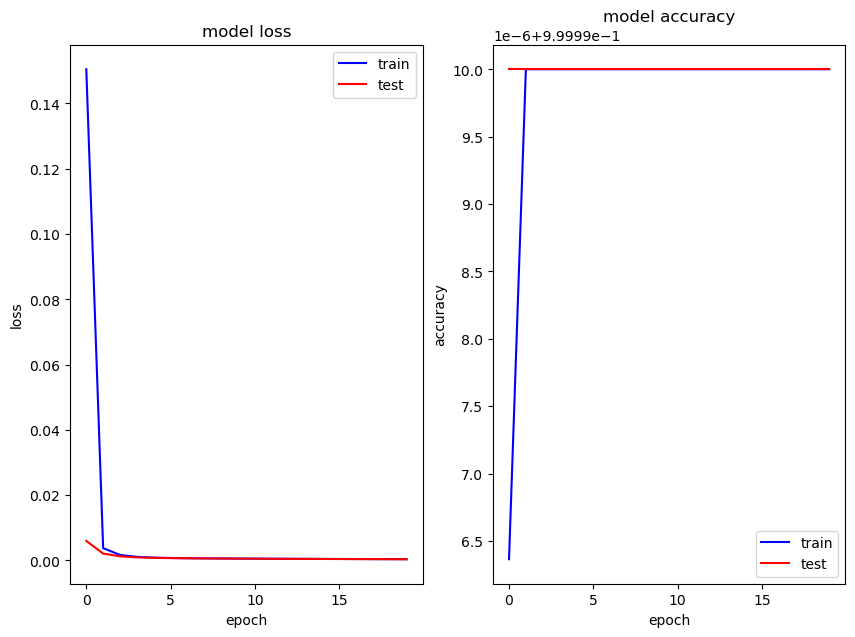

In [28]:
# Display the learning curves

fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('model loss')
ax[0].plot(history.history['loss'], 'b')
ax[0].plot(history.history['val_loss'], 'r')
ax[0].legend(['train', 'test'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('model accuracy')
ax[1].plot(history.history['acc'], 'b')
ax[1].plot(history.history['val_acc'], 'r')
ax[1].legend(['train', 'test'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

### Inference


In [29]:
# predict using the model trained in the previous step

preds = model.predict(x_val)

2/2 [==============================] - 2s 781ms/step


CPU times: user 1.26 s, sys: 102 ms, total: 1.36 s
Wall time: 1.36 s


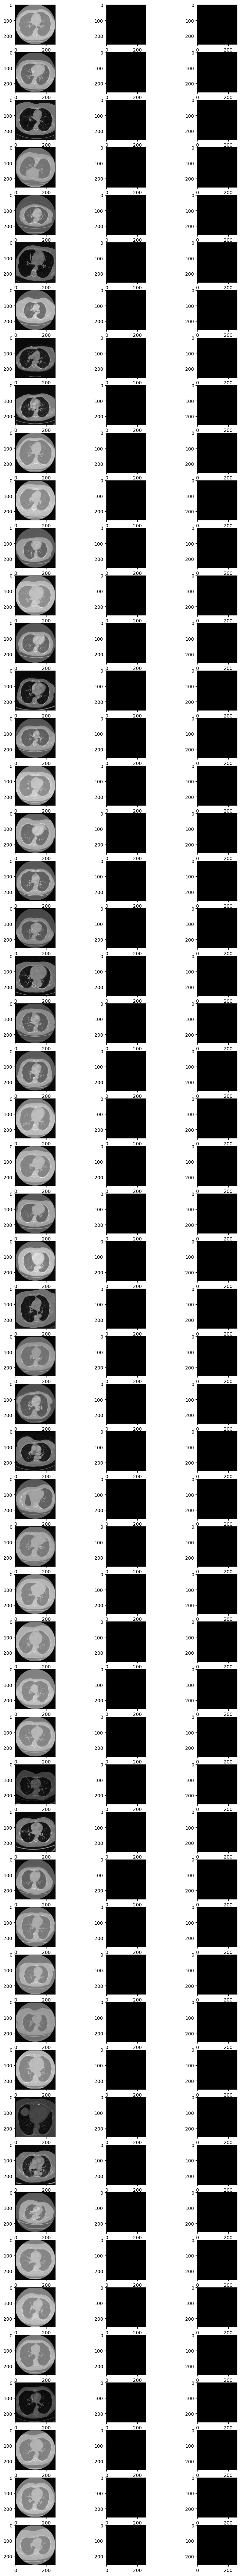

In [30]:
%%time
# show some results

fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')

### Load a pre-trained model for inference


In [31]:
model_path = '/Users/danishkarur/opt/Python Scripts/Learnings_CognitiveClasses/LungCT_platform/trained_model/'

In [32]:
# Load a model trained using the Lung CT dataset

model_pretrained = load_model(model_path + 'LungCT_Seg.model')

In [33]:
%%time
# Predictions using the pretrained model

preds_2 = model_pretrained.predict(x_val)

2/2 [==============================] - 2s 772ms/step
CPU times: user 12.6 s, sys: 1.86 s, total: 14.5 s
Wall time: 2.45 s


### Model Performance


In [34]:
def calc_dice_coef(y_true, y_pred, smooth=1):
    side = len(y_true[0])
    y_true_f = y_true.reshape(side*side)
    y_pred_f = y_pred.reshape(side*side)
    intersection = sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)

In [38]:
dice_preds = []
for it in range(len(preds)):
    dice = calc_dice_coef(preds[it], y_val[it])
    dice_preds.append(dice)
print(dice_preds)

[0.0405082195496554, 0.04050831684829601, 0.04050376852898911, 0.040508244644269706, 0.04050833808716062, 0.04050446064784199, 0.04050797128230004, 0.04050691472408144, 0.04050436115184336, 0.04050804955310536, 0.04050848518015949, 0.04050851684994358, 0.040508149865097785, 0.04050841693371395, 0.04050725513460368, 0.04050795663724713, 0.040508263322087165, 0.04050828255442936, 0.04050827502977665, 0.04050854950649931, 0.040504378916530324, 0.040508443218832055, 0.040508490480581076, 0.04050825433655434, 0.04050827733090332, 0.040507896415379496, 0.040508414293923725, 0.040503110335402055, 0.040508349386712154, 0.04050838972662678, 0.04050485086204093, 0.040507588319429626, 0.040508434790883084, 0.040507921958979606, 0.04050844176380545, 0.040508521616347416, 0.040508250545602545, 0.04050425691170235, 0.04050447211239655, 0.04050828654133451, 0.04050851389790094, 0.0405084173365954, 0.04050843286864605, 0.04050822844457785, 0.040498205873775714, 0.04050293318172079, 0.04050846262671065

In [36]:
print (f'Dice Coefficient - mean : {np.mean(dice_preds): 0.2f}')

Dice Coefficient - mean :  0.04
